# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jax.tree_util import tree_map
import jax.random as jr


# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree

# To make nice plots : 
from simulate.plot_trajectory import plot_training


# The simulated environment :
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import TrainingEnvironment,run_loop,generate_synthetic_data

# The methods to predict actions, compute the log-likelihoods and fit the models :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from functools import partial


# The artificial agents : 
from agents_full_actions import choice_kernel_agent,rw_agent,rw_ck_agent,nQL_agent,ltQL_agent,latQL_agent
from agents_full_actions import random_agent
from simulate.hmm_weights import basic_latent_model # For the active inference model


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NTRIALS = 10
T = 11

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD = 0.175# 175
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)

Ns = 5

# Depending on the dimensions of the problem :
models_constants = {
    "angle" : {
        "N_actions" : 9,
        "N_states" : Ns,
        "N_outcomes" : N_FEEDBACK_OUTCOMES
    },
    "distance" : {
        "N_actions" : 4,
        "N_states" : Ns,
        "N_outcomes" : N_FEEDBACK_OUTCOMES
    },
    "position" : {
        "N_actions" : 9,
        "N_states" : Ns,
        "N_outcomes" : N_FEEDBACK_OUTCOMES
    }
}

Example of behaviour simulated by a given model in the environment :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


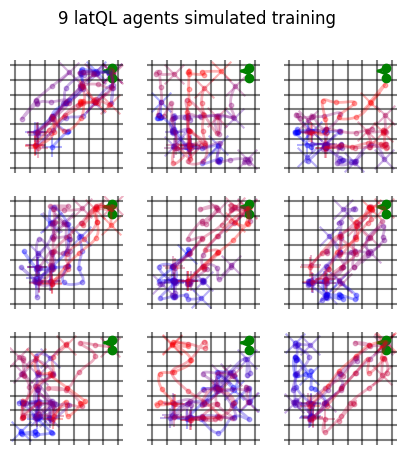

In [3]:
NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 latQL agents simulated training")

latql_agent_hyperparameters = {
    "angle":{
        "alpha_+":0.3,
        "alpha_-":0.3,
        "beta" : 30.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.2,
    },
    "position":{
        "alpha_+":0.3,
        "alpha_-":0.3,
        "beta" :30.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.2,
    },
    "distance":{
        "alpha_+":0.3,
        "alpha_-":0.3,
        "beta" : 30.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.3,
        "perception_sigma" : 0.2,
    }
}

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    params_final,training_hist = run_loop(ENVIRONMENT,latQL_agent(latql_agent_hyperparameters,models_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


# # RW agent for comparison :
# rw_agent_hyperparameters ={
#     "angle":{
#         "alpha":0.5,
#         "beta" :40.0
#     },
#     "position":{
#         "alpha":0.3,
#         "beta" :4.0
#     },
#     "distance":{
#         "alpha":0.1,
#         "beta" :40.0
#     }
# }
# fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
# fig.suptitle("9 RW agents simulated training")
# for ax in axs.reshape(-1): 
#     # In : an agent based on some hyperparameters : 
#     SEED = np.random.randint(1000)

#     params_final,training_hist = run_loop(ENVIRONMENT,rw_agent(rw_agent_hyperparameters,models_constants),SEED,NTRIALS)

#     simulated_states = np.array(training_hist["env_states"])

#     plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)

Generate some synthetic data for the model we're interested in :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25
Trial 26
Trial 27
Trial 28
Trial 29
(30, 11, 5, 5, 9)
GT LL : 
{'angle': Array(-376.54996, dtype=float32), 'distance': Array(-240.66241, dtype=float32), 'position': Array(-582.9109, dtype=float32)}
(30, 11, 9, 5)


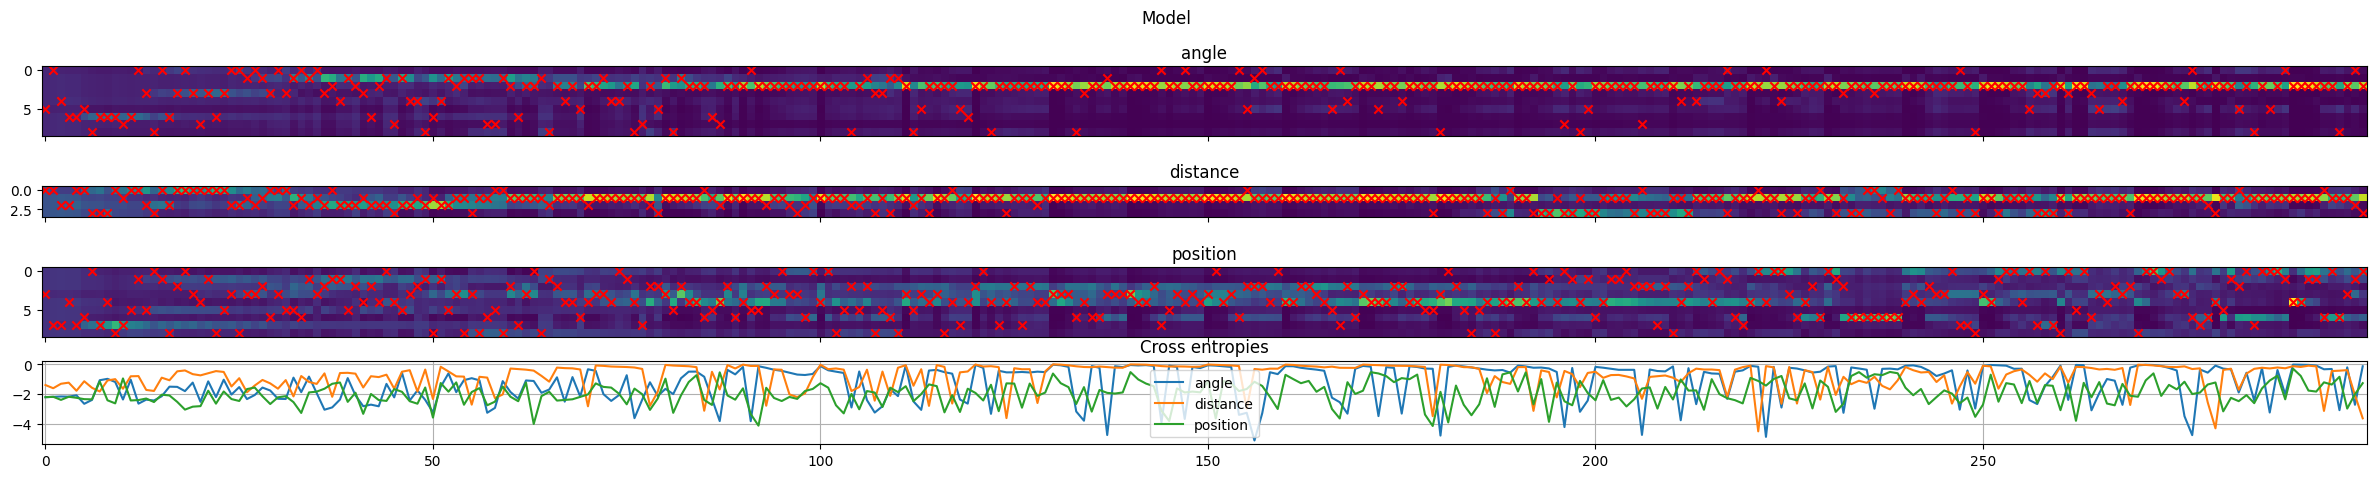

In [4]:

GT_latql_agent_hyperparameters = {
    "angle":{
        "alpha_+":0.2,
        "alpha_-":0.2,
        "beta" : 30.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.5,
        "perception_sigma" : 0.2,
    },
    "position":{
        "alpha_+":0.2,
        "alpha_-":0.2,
        "beta" :30.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.5,
        "perception_sigma" : 0.2,
    },
    "distance":{
        "alpha_+":0.2,
        "alpha_-":0.2,
        "beta" : 30.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.5,
        "perception_sigma" : 0.2,
    }
}

n_trials = 30
SYNTHETIC_DATA = generate_synthetic_data(ENVIRONMENT,latQL_agent(GT_latql_agent_hyperparameters,models_constants),
                                         n_trials=n_trials,seed = 1,verbose = True)
(formatted_stimuli,bool_stimuli,rewards,true_actions,tmtsp) = SYNTHETIC_DATA


# Optimal likelihood for the data (the best predictive power we should be able to achieve ):
(lls,ces),predictions,model_variables = compute_loglikelihood(SYNTHETIC_DATA,latQL_agent(GT_latql_agent_hyperparameters,models_constants),"sum",return_params=True)
# final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,latQL_agent(GT_latql_agent_hyperparameters,models_constants))
# model_states,other_data = state_history

predicted_actions,final_parameters = predictions
model_states,data = model_variables
qt_history,ck_history,prior_hist,a_history,b_history,_,posterior_history = model_states

print(b_history["angle"].shape)
# # plt.imshow(np.reshape(ck_history["position"],(-1,9)))
fig,axs = plt.subplots(len(true_actions)+1,1,figsize=(n_trials,5),sharex=True)
fig.suptitle("Model")

for i,key in enumerate(predicted_actions.keys()):
    ax = axs[i]

    N_action_cat = true_actions[key].shape[-1]
    
    prediction_map = np.reshape(predicted_actions[key],(-1,N_action_cat))
    ax.set_title(key)    
    ax.imshow(prediction_map.T)
        
    N_timesteps  = prediction_map.shape[0]
    ax.scatter(np.arange(N_timesteps),np.argmax(true_actions[key],axis=-1),color="red",marker="x")

ax = axs[-1]
ax.set_title("Cross entropies")
for mod,series in ces.items():
    ax.plot(series.flatten(),label=mod)
ax.legend()
ax.grid()

print("GT LL : ")
print(lls)
print(qt_history["angle"].shape)

(30, 11, 5)
(30, 11, 5)
[[0.2        0.2        0.2        0.2        0.2       ]
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.20000002 0.20000002 0.20000002 0.20000002 0.20000002]
 [0.19999999 0.19999999 0.19999999 0.19999999 0.19999999]
 [0.19999999 0.19999999 0.19999999 0.19999999 0.19999999]
 [0.35038495 0.21471044 0.15064782 0.14225812 0.14199859]
 [0.2550308  0.22505125 0.18138647 0.16961226 0.16891919]
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.3300059  0.2741727  0.17571583 0.11593767 0.10416788]
 [0.32138205 0.28986472 0.16841121 0.11406066 0.10628139]
 [0.44272056 0.3033507  0.12795581 0.06709345 0.05887961]
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.20000002 0.20000002 0.20000002 0.20000002 0.20000002]
 [0.50269544 0.29643035 0.10042085 0.05299828 0.04745499]
 [0.33429605 0.21313666 0.15592778 0.14843565 0.14820388]
 [0.20000002 0.20000002 0.20000002 0.20000002 0.20000002]
 [0.27090192 0.20693554 0.17673197 0.17277649 0.

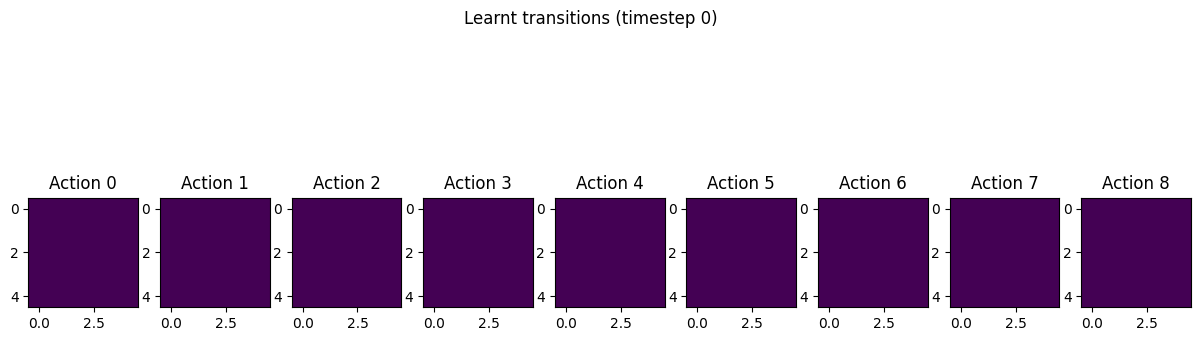

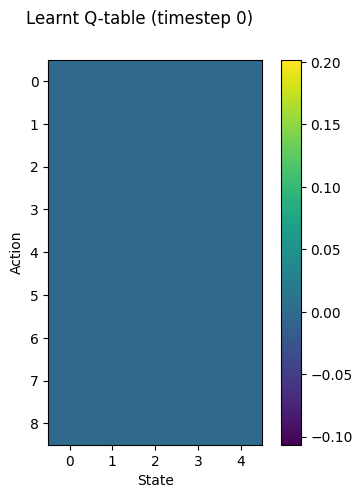

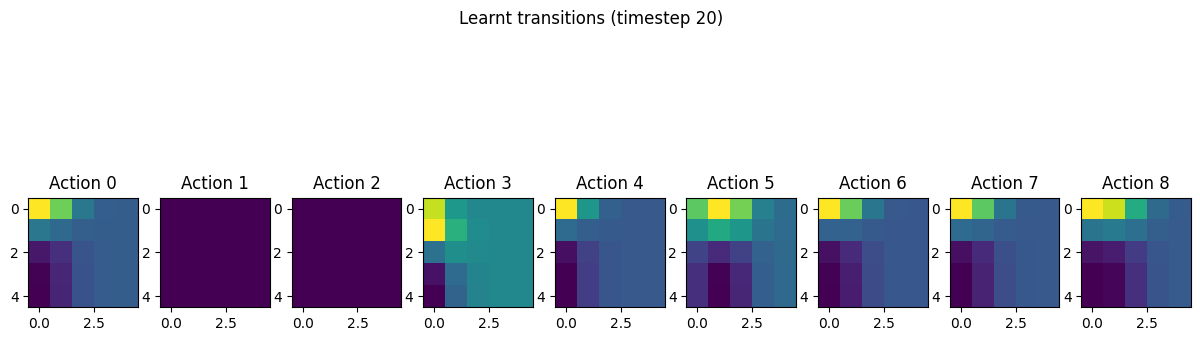

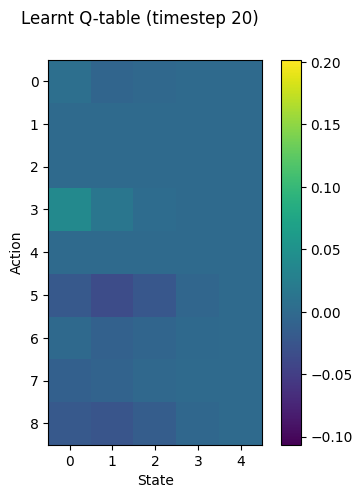

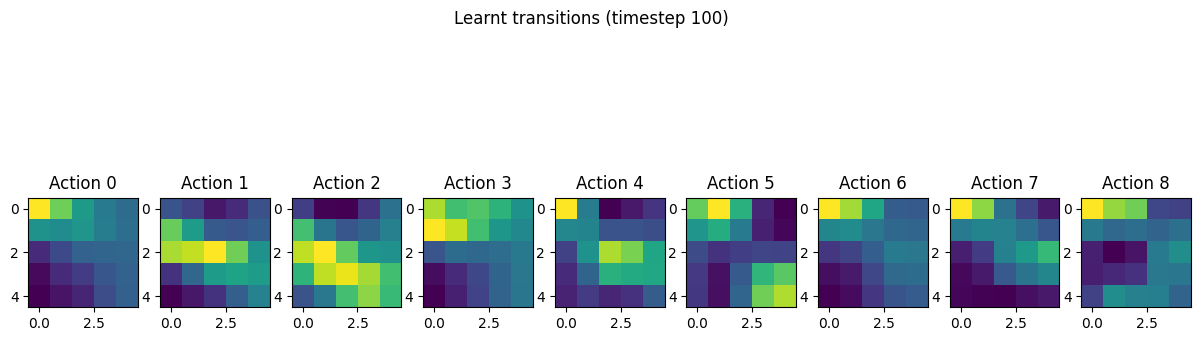

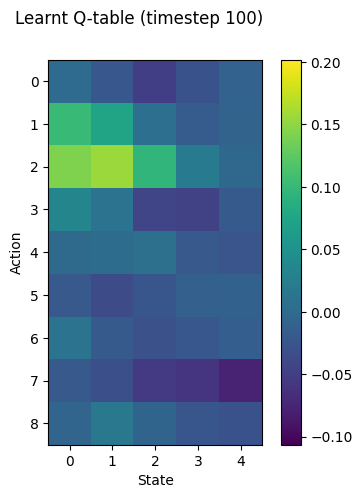

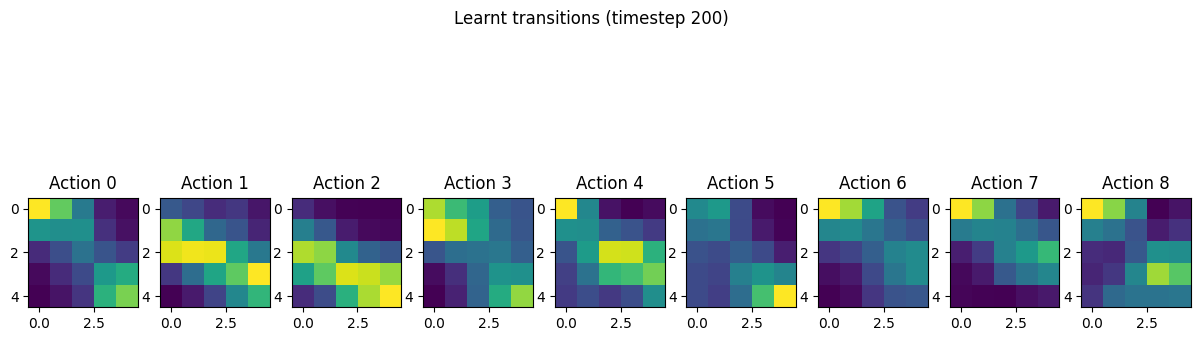

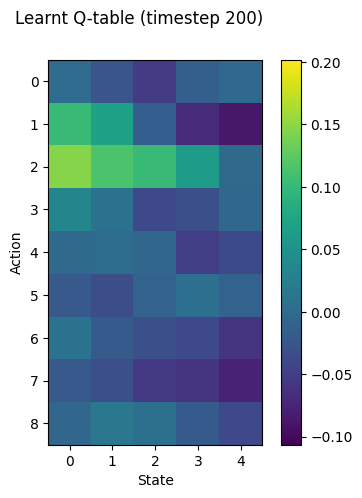

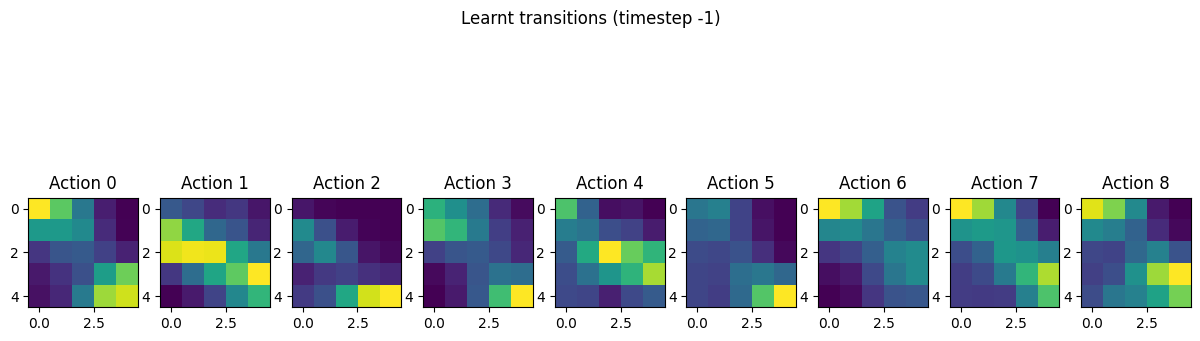

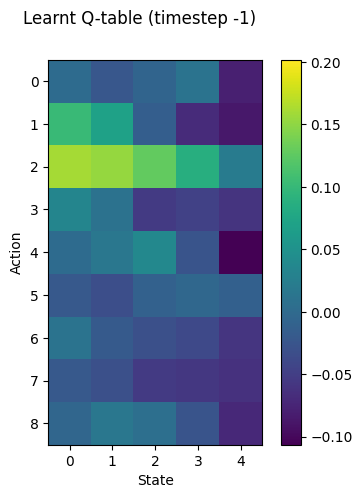

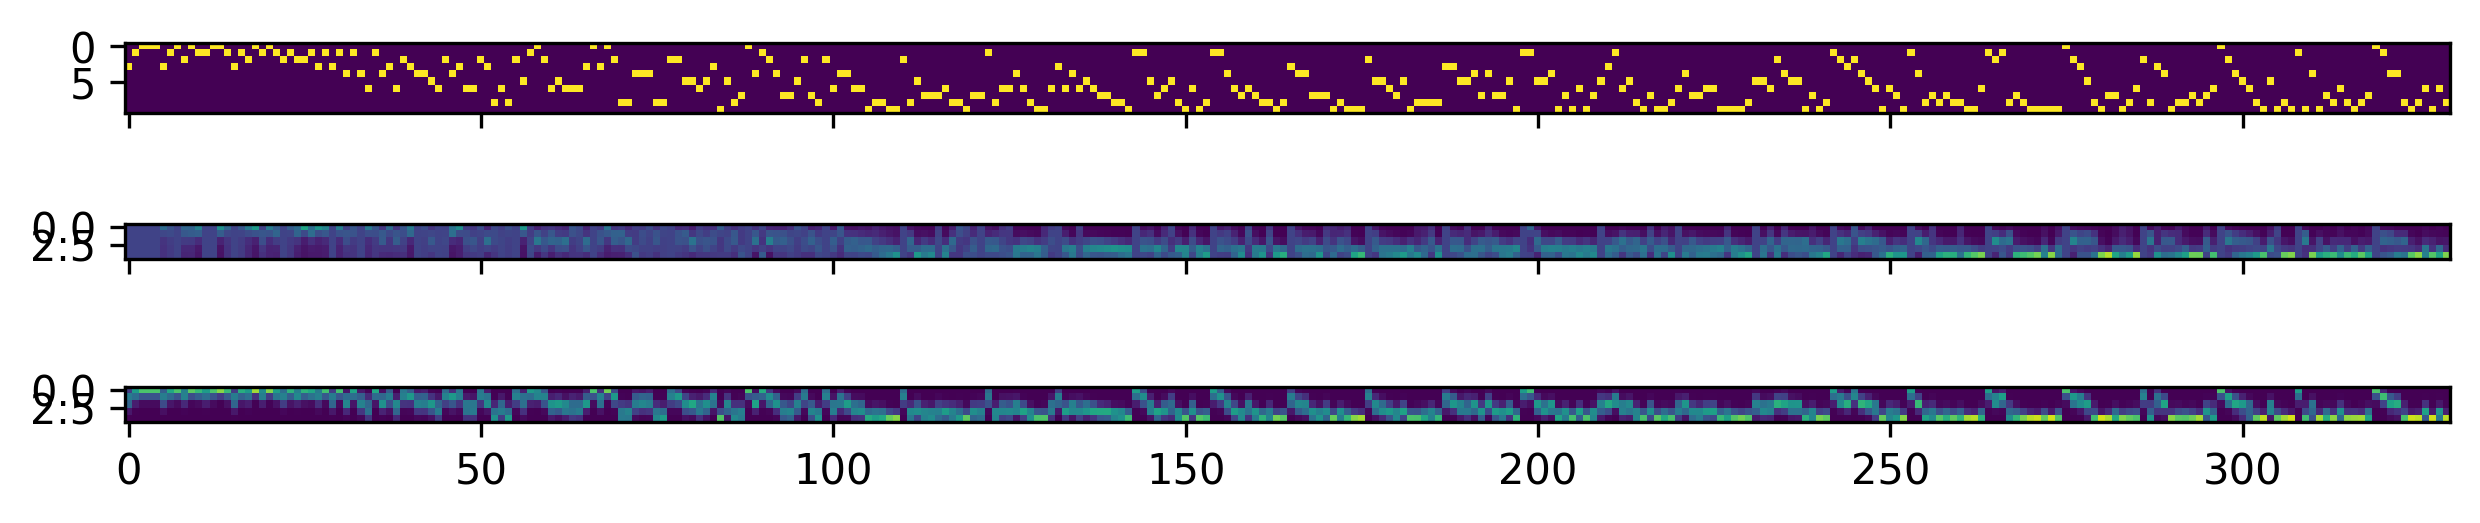

In [5]:
# Analyse the variables of this agent :

# # PLOT THE PERCEPTION MATRICES
# plt.imshow(a_history["angle"][0,0])
# plt.show()
# plt.imshow(a_history["distance"][0,0])
# plt.show()
# plt.imshow(a_history["position"][0,0])
# plt.show()

# print(b_history["angle"].shape)
Nactions = b_history["angle"].shape[-1]
one_training_episode_learnt_transitions = np.reshape(b_history["angle"],(-1,5,5,Nactions))
one_training_episode_qtables = np.reshape(qt_history["angle"],(-1,Nactions,5))
for t in [0,20,100,200,-1]:
    fig,axs = plt.subplots(1,Nactions,figsize=(15,5))
    fig.suptitle("Learnt transitions (timestep {})".format(t))
    for k, ax in enumerate(axs):
        ax.set_title("Action {}".format(k))
        im = ax.imshow(_normalize(one_training_episode_learnt_transitions[t,...,k])[0])
    
    fig,ax = plt.subplots(1,figsize=(5,5))
    fig.suptitle("Learnt Q-table (timestep {})".format(t))
    im = ax.imshow(one_training_episode_qtables[t,...],cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
    ax.set_xlabel("State")
    ax.set_ylabel("Action")
    fig.colorbar(im)

# Priors are recorded in a weird way (prior_hist only stores priors for the next timestep). Here is a manual fix : 
ph_raw = prior_hist["angle"]
print(ph_raw.shape)

_,_,_,_,d = final_parameters


Ntrials,Ntimesteps,Nstates = ph_raw.shape
static_prior = np.repeat(np.expand_dims(d["angle"],(0,1)),Ntrials,axis=0)

ph_fixed = np.concatenate((static_prior,ph_raw[:,:-1,:]),axis=1)
print(ph_fixed.shape)
# print(np.concatenate([np.expand_dims(d,(0,1)),]))
# ph_fixed = np.concatenate()
# prior_hist_fixed = 

prior_across_t = np.reshape(ph_fixed,(-1,5))
posterior_across_t = np.reshape(posterior_history["angle"],(-1,5)) # Posteriors are fine


extract_priors= prior_across_t[:20,:]
print(extract_priors)
print(np.sum(extract_priors,axis=-1))

fig,axs = plt.subplots(3,1,figsize=(10,2),dpi=300,sharex=True)
axs[0].imshow(np.reshape(formatted_stimuli[0],(-1,N_FEEDBACK_OUTCOMES)).T,vmin=0,vmax=1)
axs[1].imshow(prior_across_t.T,vmin=0,vmax=1)
axs[2].imshow(posterior_across_t.T,vmin=0,vmax=1)
plt.show()


step 0, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([4921.316 , 5306.5967, 6098.0566, 2358.6147, 2110.5771, 5093.209 ,
       2923.6975, 3127.7249, 3817.7717, 9426.765 , 9243.974 , 4301.083 ,
       2558.4902, 6404.342 , 2396.924 , 2531.9846, 3062.7217, 1717.2448,
       4762.605 , 9295.073 , 2681.898 , 4990.471 , 3061.0034, 4653.626 ,
       6809.227 , 4283.917 , 9268.236 , 2353.8945, 4175.507 , 4795.3545,
       4199.073 , 2731.5962, 4575.8774, 4305.036 , 6620.4673, 4594.46  ,
       2804.1665, 9422.279 , 1984.8333, 4883.415 , 8887.236 , 2949.157 ,
       6121.052 , 2359.0786, 7994.764 , 2074.8604, 7157.5044, 9221.6   ,
       3094.4468, 6634.6587], dtype=float32)
  batch_dim = 0
step 10, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([4160.86  , 4740.136 , 5686.7793, 2174.7979, 1680.531 , 4613.6055,
       2467.813 , 2673.642 , 3503.8083, 9366.505 , 9119.219 , 4142.5874,
       2199.2397, 5821.668 , 2236.1565

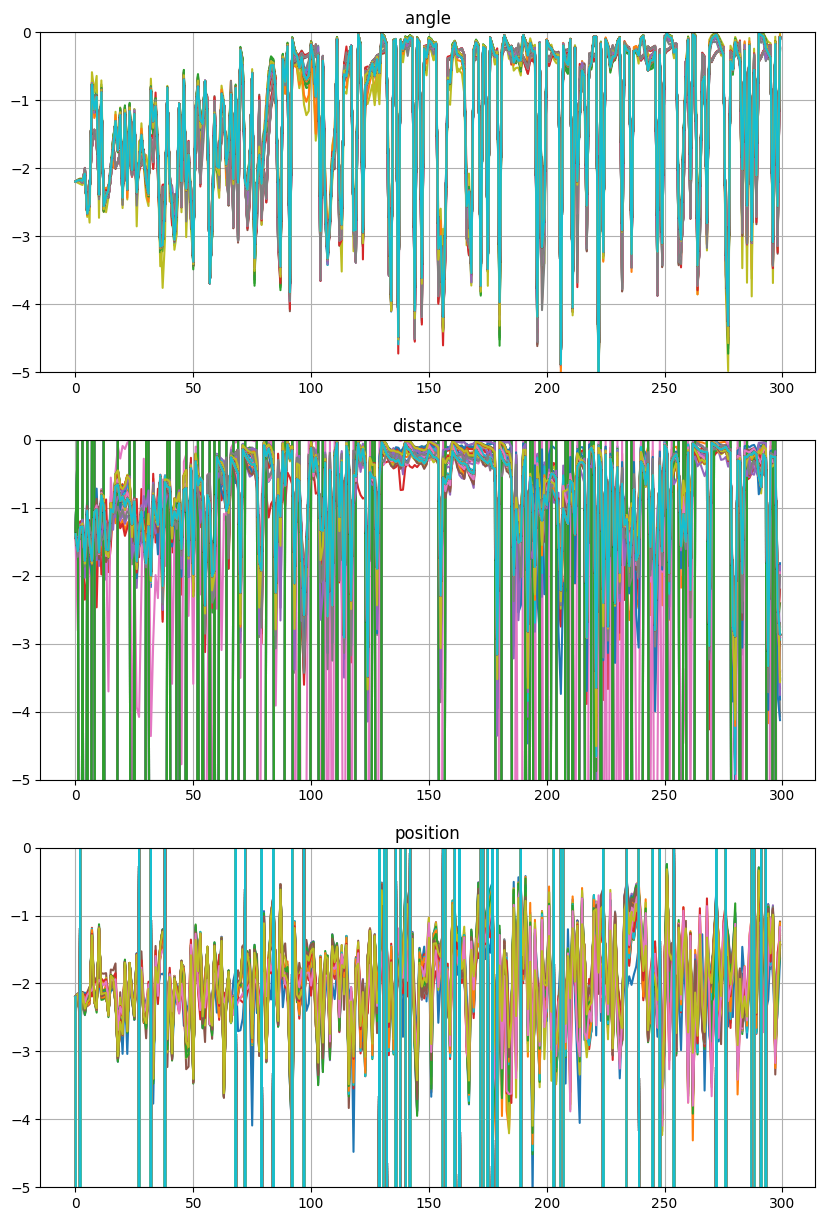

In [6]:


# Assuming uniform distributions for all parameters :
feature_range_tree ={
    "angle":{
        "alpha_+":jnp.array([-10,10]),
        "alpha_-":jnp.array([-10,10]),
        "beta" :jnp.array([0,10]),
        "alpha_ck":jnp.array([-10,10]),
        "beta_ck" :jnp.array([0,10]),
        "transition_alpha":jnp.array([-10,10]),
        "perception_sigma":jnp.array([0,5]),
    },
    "position":{
        "alpha_+":jnp.array([-10,10]),
        "alpha_-":jnp.array([-10,10]),
        "beta" :jnp.array([0,50]),
        "alpha_ck":jnp.array([-10,10]),
        "beta_ck" :jnp.array([0,50]),
        "transition_alpha":jnp.array([-10,10]),
        "perception_sigma":jnp.array([0,5]),
    },
    "distance":{
        "alpha_+":jnp.array([-10,10]),
        "alpha_-":jnp.array([-10,10]),
        "beta" :jnp.array([0,50]),
        "alpha_ck":jnp.array([-10,10]),
        "beta_ck" :jnp.array([0,50]),
        "transition_alpha":jnp.array([-10,10]),
        "perception_sigma":jnp.array([0,5]),
    }
}
static_agent = partial(latQL_agent,constants= models_constants)

all_fin_params,(gt_mle,all_losses,all_param_histories),encoding_function = fit_mle_agent(SYNTHETIC_DATA,
                            static_agent,feature_range_tree,jax.random.PRNGKey(0),
                            n_heads=50,num_steps=250,verbose=True)

final_lls,cross_entropies = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,static_agent(encoding_function(x)),"sum"))(all_fin_params)

print(cross_entropies["angle"])
print(min(final_lls["angle"]))
print(max(final_lls["angle"]))
fig,axs = plt.subplots(3,1,figsize=(10,15))
for i,key in enumerate(cross_entropies.keys()):
    axs[i].set_title(key)
    for head in range(100):
        axs[i].plot(cross_entropies[key][head].flatten())
    axs[i].set_ylim(ymax=0.0,ymin=-5)
    axs[i].grid()
plt.show()

Given the best match for subject parameters, we then reconstruct the evolution of model states / parameters across trials.

(330, 9, 5)


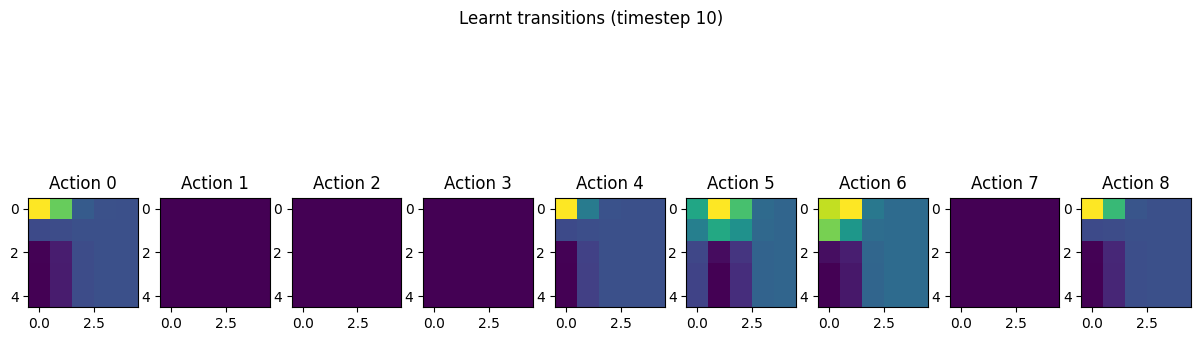

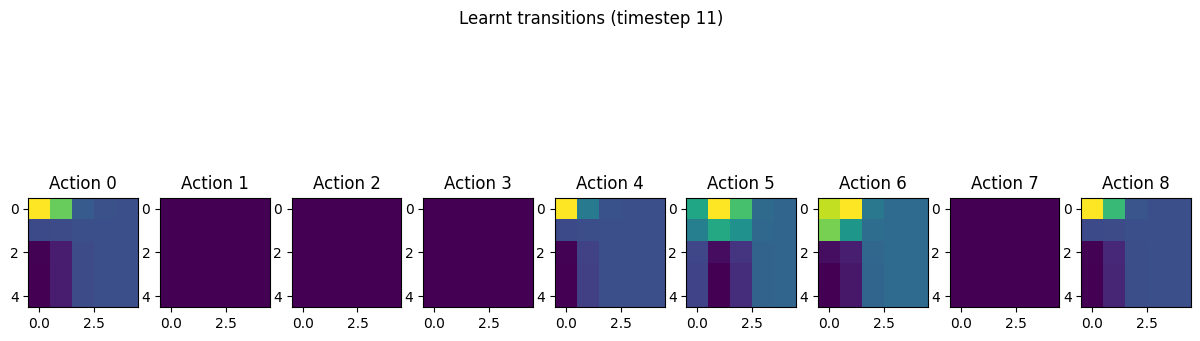

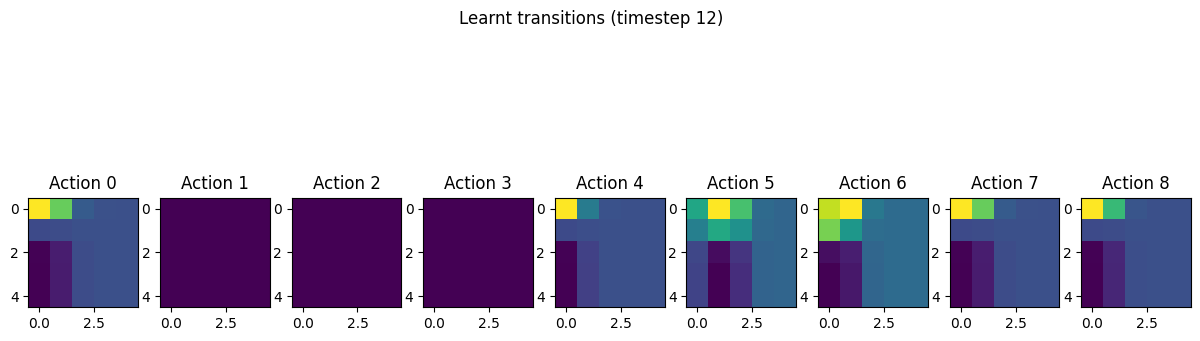

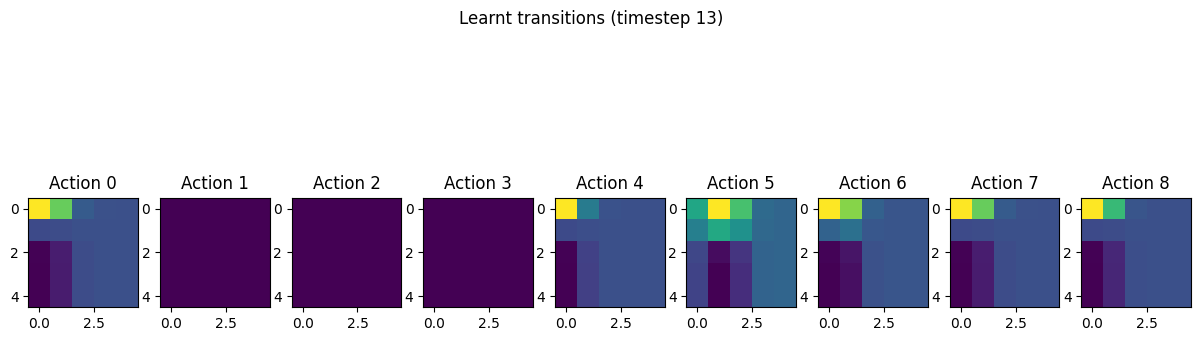

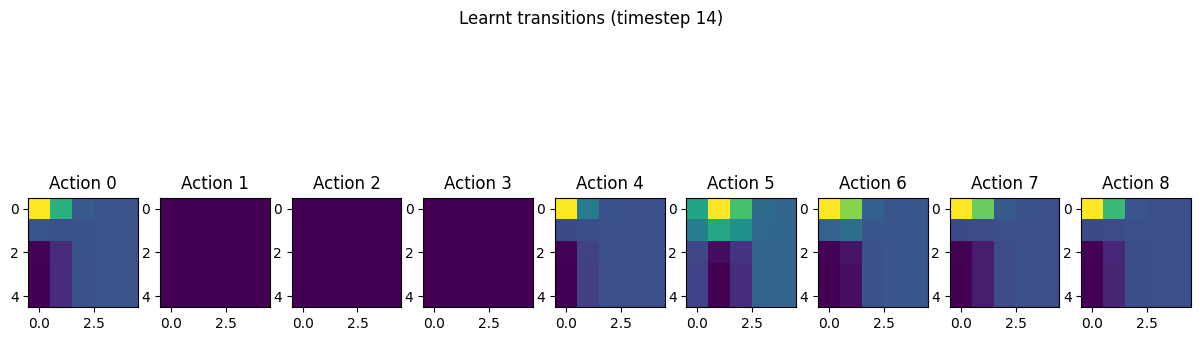

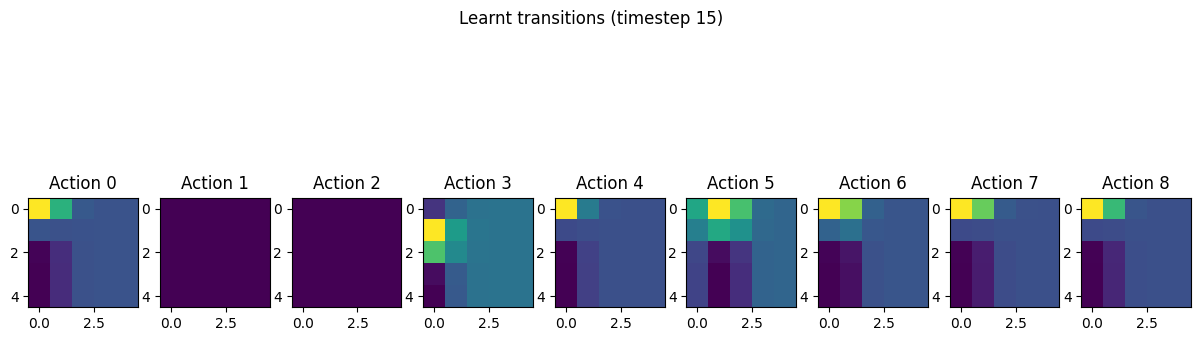

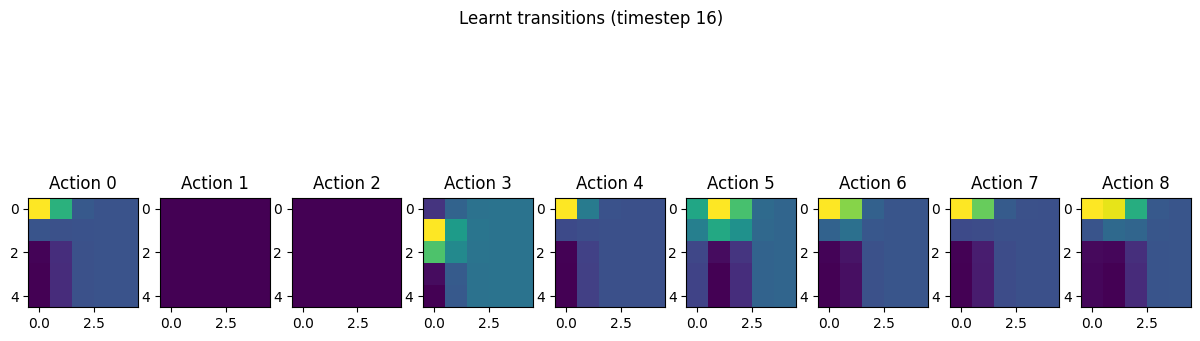

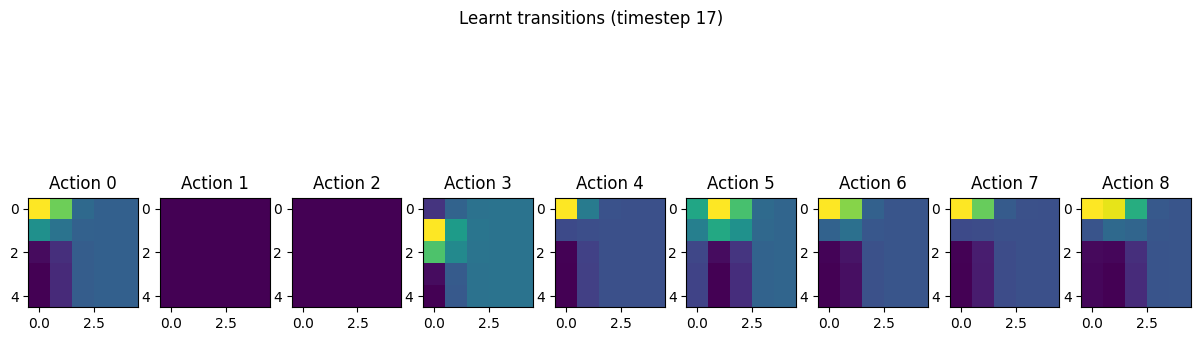

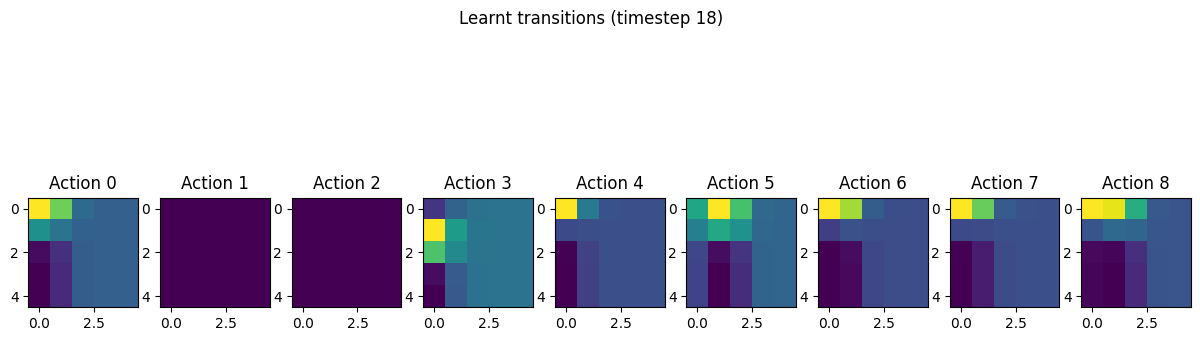

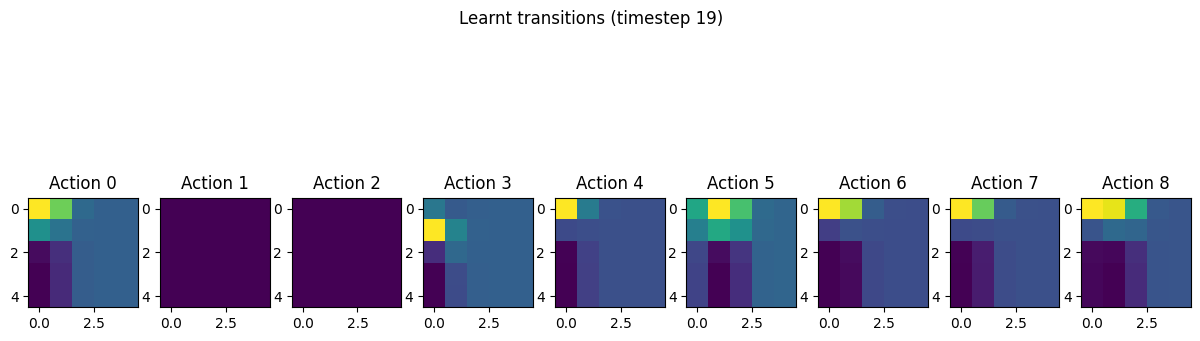

In [7]:

(lls,ces),predictions,model_variables = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,static_agent(encoding_function(x)),"sum",True))(all_fin_params)

predicted_actions,final_parameters = predictions
model_states,data = model_variables
qt_history,ck_history,prior_hist,a_history,b_history,_,posterior_history = model_states


one_training_episode_learnt_transitions = np.reshape(b_history["angle"][0],(-1,5,5,9))

one_training_episode_qtables = np.reshape(qt_history["angle"][0],(-1,9,5))

print(one_training_episode_qtables.shape)

# import imageio,PIL

# images = {[]}
# for t in one_training_episode_learnt_transitions.shape[0]:
#     images.append(imageio.imread(filename))
# imageio.mimsave('/path/to/movie.gif', images)
Nactions = one_training_episode_learnt_transitions.shape[-1]

for t in [10+i for i in range(10)]:
    fig,axs = plt.subplots(1,Nactions,figsize=(15,5))
    fig.suptitle("Learnt transitions (timestep {})".format(t))
    for k, ax in enumerate(axs):
        ax.set_title("Action {}".format(k))
        im = ax.imshow(_normalize(one_training_episode_learnt_transitions[t,...,k])[0])
    
    # fig,ax = plt.subplots(1,figsize=(5,5))
    # fig.suptitle("Learnt Q-table (timestep {})".format(t))
    # im = ax.imshow(one_training_episode_qtables[t,...],cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
    # ax.set_xlabel("State")
    # ax.set_xlabel("Action")
    # fig.colorbar(im)

(330, 5, 5, 9)
(330, 5)


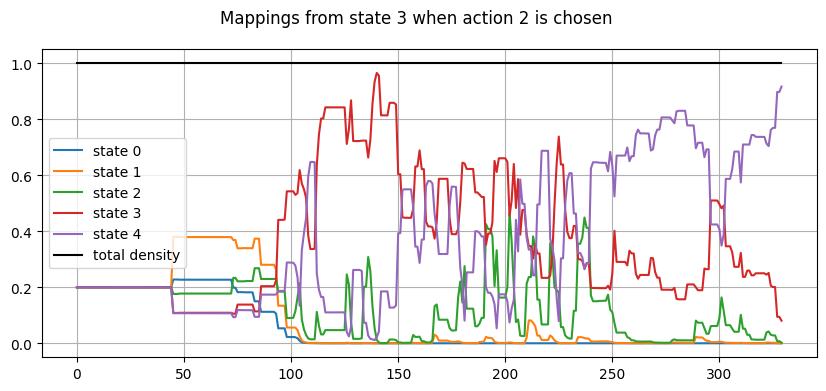

In [8]:
# Let's focus on a single part of the learnt action mapping : the mapping from state i and action u :

print(one_training_episode_learnt_transitions.shape)

i = 3
u = 2
am = one_training_episode_learnt_transitions[:,:,i,u]
print(am.shape)


fig,ax = plt.subplots(figsize=(10,4))
fig.suptitle("Mappings from state {} when action {} is chosen".format(i,u))
for s in range(am.shape[-1]):
    ax.plot(am[:,s],label="state {}".format(s))
ax.plot(np.sum(am,axis=-1),color="black",label="total density")
ax.grid()
ax.legend()